# Simulating ODE Models with PEtab in Julia

This document details how to simulate the dynamic Ordinary Differential Equation (ODE) model in a [PEtab](https://petab.readthedocs.io/en/latest/) problem. This notebook is the foundation for other PEtab notebooks, such as how to select the best ODE solver ADD. 

## Setup

The packages needed are:

- **PEtab.jl**: For importing PEtab problems.
- **OrdinaryDiffEq.jl**: For simulating ODE models.
- **Plots.jl**: For visualizing simulation results.


In [1]:
using OrdinaryDiffEq, PEtab, Plots

## Importing and simulating a model

As a case study, we use a Jak-Stat signaling model where the PEtab problem files are located in the *Assets/Boehm_JProteomeRes2014/* directory. To begin, we import the PEtab problem into Julia by constructing a `PEtabModel`:

In [2]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Boehm_JProteomeRes2014", "Boehm_JProteomeRes2014.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)

PEtabModel for model Boehm_JProteomeRes2014. ODE-system has 8 states and 10 parameters.
Generated Julia files are at /home/sebpe/Dropbox/PhD/Projects/SysBioNotebooks/PEtab/Assets/Boehm_JProteomeRes2014/Julia_model_files

During the import several things happen. The SBML model is imported as a reaction system, which then is converted into an `ODESystem`. The other PEtab files are parsed to generate functions essential for evaluating the likelihood and its gradients. The likelihood quantifies the deviation between the model's predictions and the observed experimental data.

The `PEtabModel` can be transformed into a parameter estimation problem for ODEs by initializing a `PEtabODEProblem`:

In [3]:
petab_problem = PEtabODEProblem(petab_model; verbose=false)
nothing

There are many available options when building a `PEtabODEProblem` (see [here](https://sebapersson.github.io/PEtab.jl/stable/API_choosen/)). If no options are specified good defaults are used.

### Simulating the PEtab Model

Simulating a PEtab problem requires three components: the `ODEProblem` to solve, the model's parameter values, and its initial values. We begin with the `ODEProblem`, which can be extracted via:

In [4]:
oprob = petab_problem.ode_problem

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5000.0)
u0: 8-element Vector{Float64}:
 143.86679999999998
   0.0
   0.0
   0.0
  63.73320000000001
   0.0
   0.0
   0.0

Next, to solve the `ODEProblem`, we need to specify the model's parameters and initial values. To retrieve the parameter values defined in the PEtab file do:

In [5]:
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

9-element Vector{Pair{Symbol, Float64}}:
 :Epo_degradation_BaF3 => -1.5689175883999988
         :k_exp_hetero => -4.999704893599998
           :k_exp_homo => -2.2096987817000167
         :k_imp_hetero => -1.78600654750001
           :k_imp_homo => 4.9901140088
               :k_phos => 4.1977354885
       :sd_pSTAT5A_rel => 0.5857552705999998
       :sd_pSTAT5B_rel => 0.8189828191999999
       :sd_rSTAT5A_rel => 0.49868440400000047

The parameters in the PEtab problem (`xpetab`) are the parameters set to be estimated, and are typically on a log10 scale to improve parameter estimation performance. These parameters may correspond to both the parameters and initial values within the `ODEProblem`. This mapping can be complex, but extracting the parameters (`p`) and initial values (`u0`) for the `ODEProblem` is a straightforward task with the following two utility functions:

In [6]:
# Initial values
u0 = get_u0(xpetab, petab_problem)
# Parameter values
p = get_ps(xpetab, petab_problem)

10-element Vector{Pair{Symbolics.Num, Float64}}:
              specC17 => 0.107
 Epo_degradation_BaF3 => 0.026982514033028992
           k_exp_homo => 0.006170228086380998
               k_phos => 15766.507019573099
                ratio => 0.693
           k_imp_homo => 97749.37940247158
         k_imp_hetero => 0.0163679184468
         k_exp_hetero => 1.00067973851508e-5
                  cyt => 1.4
                  nuc => 0.45

We can now solve the model using an ODE solver, such as `Rodas5P`:

In [7]:
sol = solve(oprob, Rodas5P(), p=p, u0=u0)
nothing

and we can plot the ODE solution for a specie, lets stats `STAT5B`, by:

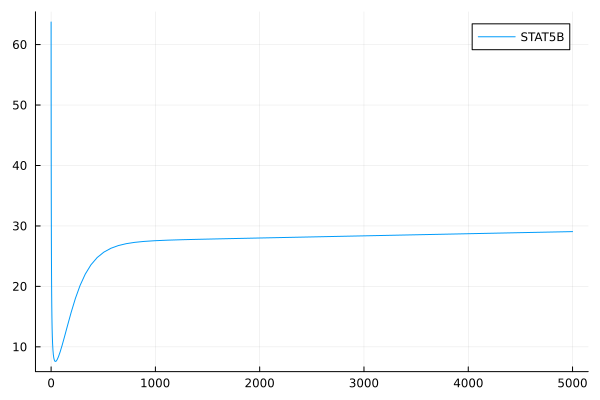

In [8]:
plot(sol.t, sol[:STAT5B], label="STAT5B")

To modify the value of a parameter within `xpetab`, like `k_phos`, do:

In [9]:
ikphos = findfirst(x -> x == :k_phos, xpetab_names)
xpetab[ikphos] = log10(2.0)

0.3010299956639812

Keep in mind to apply the log10 scale to `k_phos`, as its values are represented on this scale in PEtab (the parameter scale is detailed within the PEtab files). With the updated parameters, the ODE can now be solved anew:

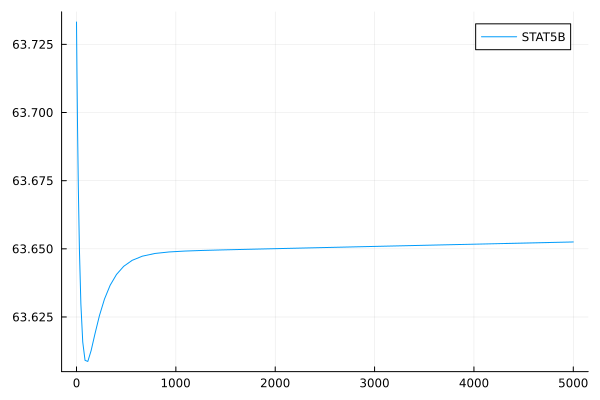

In [10]:
u0 = get_u0(xpetab, petab_problem)
p = get_ps(xpetab, petab_problem)
sol = solve(oprob, Rodas5P(), p=p, u0=u0)
plot(sol.t, sol[:STAT5B], label="STAT5B")

For additional notes on how to interact with the `ODESolution` (here called `sol`), see the documentation for [OrdinaryDiffEq](https://docs.sciml.ai/DiffEqDocs/latest/).

## Importing a Model with Multiple Simulation Conditions

The JAK-STAT PEtab problem features only a single simulation condition. However, in scenarios where the experimental data are collected under different experimental conditions (e.g. different insulin dosages), the model is often simulated for several simulations conditions when comparing it against data.

As an example, we use an insulin signaling model where the insulin dosage differs across simulation conditions. The simulation conditions are defined when building setting up the PEtab problem. The initial step involves importing the model followed by the extraction of the `ODEProblem` and the model parameters as above:

In [11]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Brannmark_JBC2010", "Brannmark_JBC2010.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)
petab_problem = PEtabODEProblem(petab_model; verbose=false)
oprob = petab_problem.ode_problem
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters 
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

22-element Vector{Pair{Symbol, Float64}}:
           :k1a => -0.7514885476590553
      :k1aBasic => -3.405864008509429
           :k1b => -0.7577170922391991
           :k1c => -1.293645232310687
           :k1d => 5.698970004335999
           :k1e => -5.999999999999961
           :k1f => 5.69896999739092
           :k1g => 3.237889565629559
           :k1r => -1.573547444249427
           :k21 => 0.32271155833067466
                ⋮
           :km3 => -0.38050753064880916
    :sigmaYDosR => 1.2449775475756601
   :sigmaY1TimR => 0.47228985123521133
   :sigmaY2TimR => 1.01567780170684
   :sigmaY2Step => 0.7121142102937158
  :k_IRSiP_DosR => 1.5791375941526697
   :k_IRP_1Step => 5.30102964860015
 :k_IRSiP_1Step => 1.6547376787228398
 :k_IRSiP_2Step => 1.4315997296248502

To obtain the specific parameters for a given condition, such as `Dose_001` or `Dose_100`, use the condition ID (as specified in the PEtab files) with `get_ps` and `get_u0` functions.

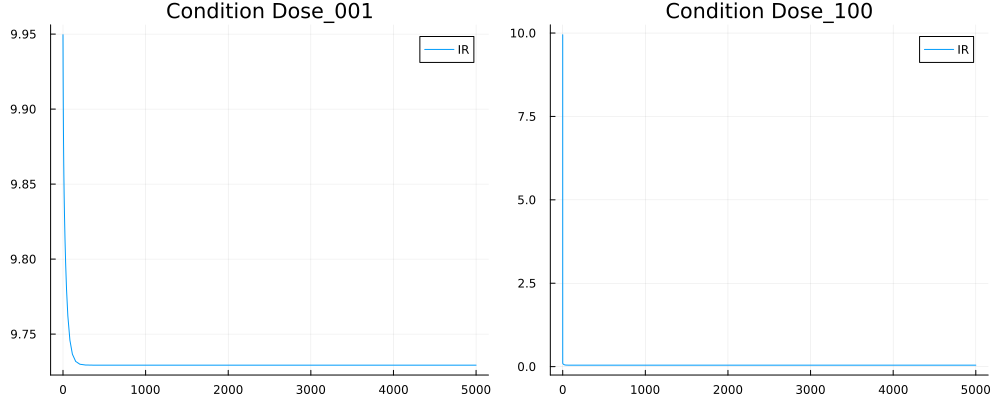

In [12]:
# For Dose_001
p = get_ps(xpetab, petab_problem; condition_id=:Dose_001)
u0 = get_u0(xpetab, petab_problem; condition_id=:Dose_001)
sol = solve(oprob, Rodas5P(), p=p, u0=u0)
p1 = plot(sol.t, sol[:IR], title = "Condition Dose_001", label="IR")
# For Dose_100
p = get_ps(xpetab, petab_problem; condition_id=:Dose_100)
u0 = get_u0(xpetab, petab_problem; condition_id=:Dose_100)
sol = solve(oprob, Rodas5P(), p=p, u0=u0)
p2 = plot(sol.t, sol[:IR], title = "Condition Dose_100", label="IR")
plot(p1, p2, layout=(1, 2), size=(1000, 400))

To streamline the process of solving the model across all experimental conditions, you can use the `solve_all_conditions` function. For example, to solve the ODE with the `Rodas5P()` solver:

In [13]:
sols, could_solve = PEtab.solve_all_conditions(xpetab, petab_problem, Rodas5P())
sols

Dict{Symbol, Union{Nothing, ODESolution}} with 8 entries:
  :Dose_0Dose_01  => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_0   => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_10  => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_100 => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_001 => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_3   => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0TwoSteps => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …
  :Dose_0Dose_1   => ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, …

Here `sols` is a dictionary containing all the ODE solutions, while `could_solve` is a Boolean variable that indicates whether the model was successfully solved. To visualize the results for a specific condition, such as *Dose_0TwoSteps* (where the model is first brought to a steady state under the *Dose_0* condition before simulating a double dosage of insulin with condition *TwoSteps*), you can use `sols` as:

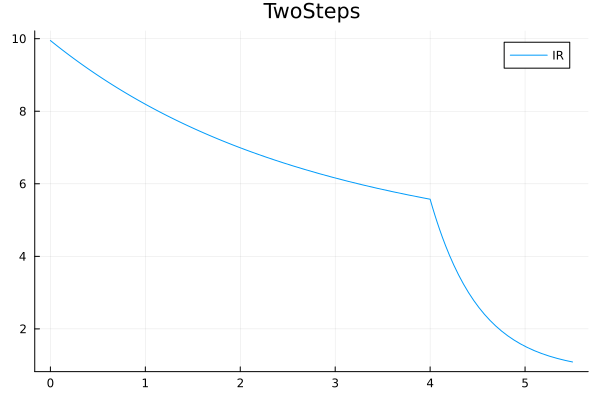

In [14]:
sol = sols[:Dose_0TwoSteps]
p2 = plot(sol.t, sol[:IR], title = "TwoSteps", label="IR")

## Next Steps

This guide has provided an introduction to basic model solving within the PEtab framework. For most modeling tasks it is crucial to use a good ODE-solver. For a guide on evaluating solver runtime and accuracy, see ADD!.